<a href="https://colab.research.google.com/github/MonikaLamba/2-GeS/blob/main/ARIMA_12_NOV_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model.ARIMA import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [49]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/content/data set arima1.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Nifty 50,Returns
Date,,
2019-01-01,10830.950200,0.000000
2019-02-01,10792.500000,-0.003556
2019-03-01,11623.900390,0.074212
2019-04-01,11748.150390,0.010632
2019-05-01,11922.799810,0.014757
2019-06-01,11788.849610,-0.011298
2019-07-01,11118.000000,-0.058589
2019-08-01,11023.250000,-0.008559
2019-09-01,11474.450200,0.040116


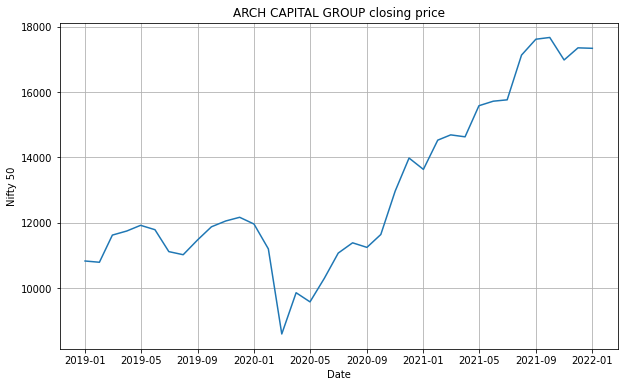

In [50]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Nifty 50')
plt.plot(stock_data['Nifty 50'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

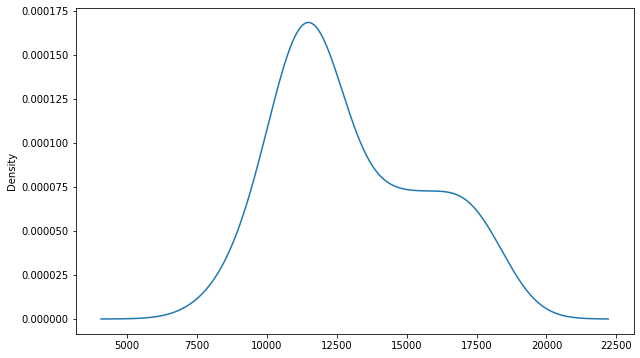

In [51]:
#Distribution of the dataset
df_close = stock_data['Nifty 50']
df_close.plot(kind='kde')


In [52]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

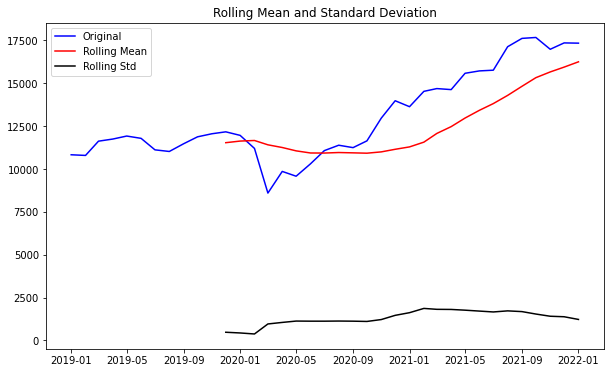

Results of dickey fuller test
Test Statistics                -0.172709
p-value                         0.941697
No. of lags used                0.000000
Number of observations used    36.000000
critical value (1%)            -3.626652
critical value (5%)            -2.945951
critical value (10%)           -2.611671
dtype: float64


In [53]:
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

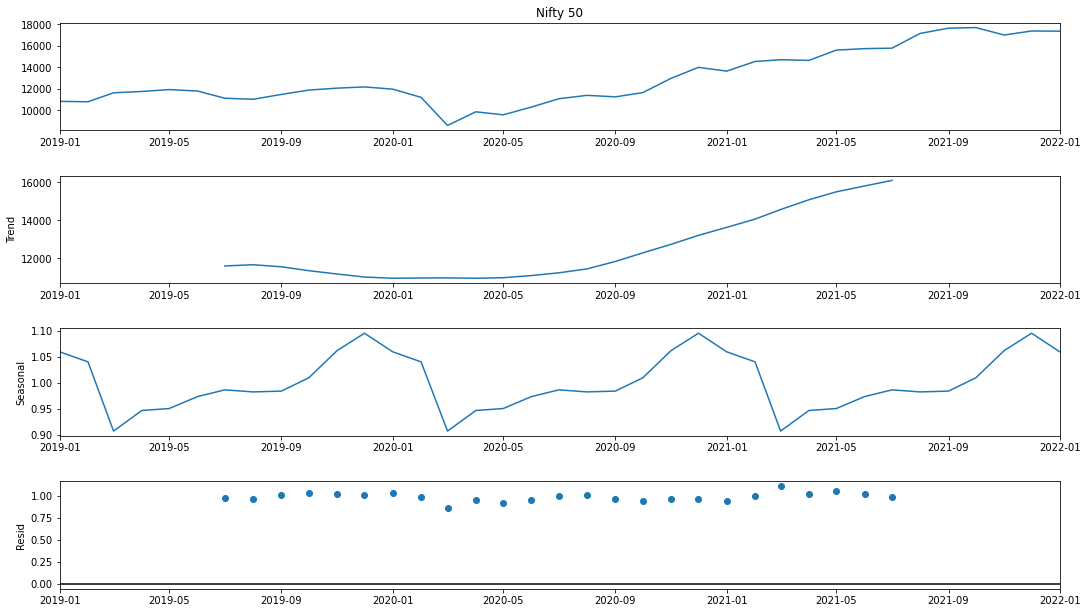

In [54]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

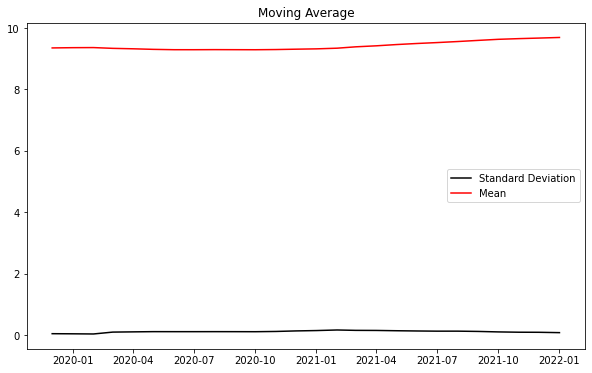

In [55]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

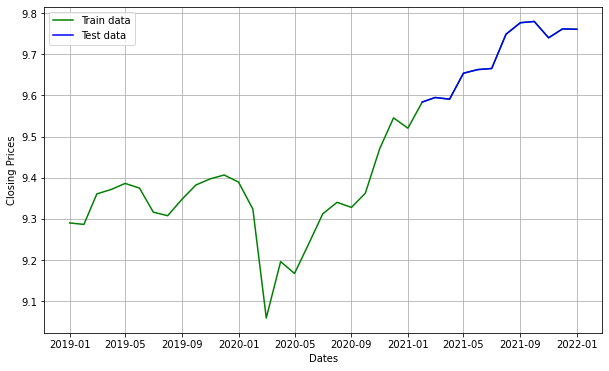

In [56]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.7)], df_log[int(len(df_log)*0.7):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-25.191, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-30.035, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-27.185, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-29.358, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-31.998, Time=0.25 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-30.165, Time=0.28 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-28.138, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-33.028, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-34.819, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-36.819, Time=0.08 sec
 A

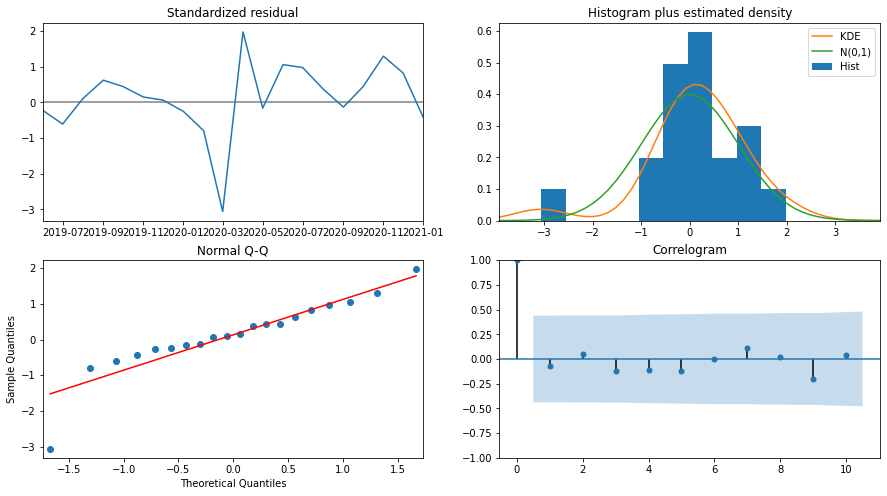

In [57]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [58]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

#warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)

#Modeling
# Build Model
#import statsmodels.tsa.arima.model.ARIMA
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model.ARIMA import ARIMA
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:               Nifty 50   No. Observations:                   22
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  23.906
Date:                Sat, 12 Nov 2022   AIC                            -39.813
Time:                        04:05:56   BIC                            -35.635
Sample:                    04-01-2019   HQIC                           -38.906
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7957      0.950      0.837      0.402      -1.067       2.659
ma.L1         -0.9318      6.451     -0.144      0.885     -13.576      11.712
ma.L2         -0.0596      0.421     -0.142      0.8

In [ ]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))
result = model.fit()
print(result.summary())

In [77]:
train =stock_data[:10]
test = stock_data[10:]

In [79]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2)).fit()

#model2 = ARIMA(train,order=(5,0,4)).fit()



In [80]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
pred = model.predict()

In [91]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(train_data,pred))
error

1.9994235974030163

In [86]:
pred.head()

2019-04-01    0.000000
2019-05-01    9.371451
2019-06-01    9.385505
2019-07-01    9.374100
2019-08-01    9.319723
Freq: MS, Name: predicted_mean, dtype: float64

In [87]:
train_data.mean(), np.sqrt(train_data.var())

(9.343013957338012, 0.10920346407525419)

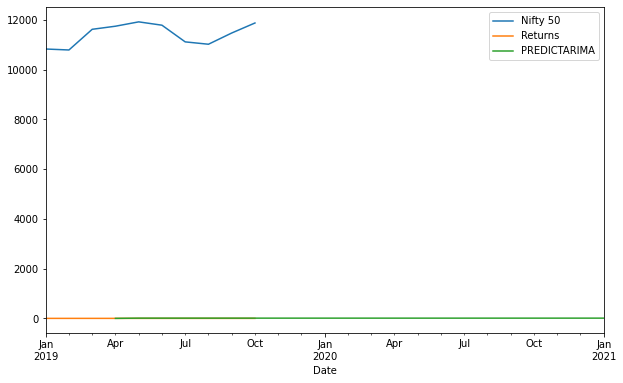

In [89]:
train.plot(legend=True, label='TRAIN',figsize=(10,6))
pred.plot(legend=True, label='PREDICTARIMA')


In [68]:
import statsmodels
statsmodels.__version__

#!pip install statsmodels --upgrade
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model, dynamic = false)
plt.show()

NameError: ignored

In [70]:
#from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.api as sm
arima_model = sm.tsa.arima.ARIMA(train_data, order(1,1,2)).fit()
model1=arima_model.fit()
print(model1.summary())
model1.plot_predict(dynamic=false)
plt.show()

NameError: ignored

In [72]:
# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: ignored